In [1]:
# SpnAsp experiment test notebook

In [1]:
import time
import sys
#sys.path.append('../../')
sys.path.append('../')
sys.path.append('../SLASH/')
sys.path.append('../EinsumNetworks/src/')
sys.path.append('../SlotAttentionObjDiscovery/')


#torch, numpy, ...
import torch
from torch.utils.tensorboard import SummaryWriter
torch.cuda.empty_cache()

import numpy as np
import importlib
import matplotlib.pyplot as plt

plt.style.use(["science", "grid"])  # Need SciencePlots pip package

import matplotlib
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": False,
    }
)


import utils


from slash import SLASH
from dataGen import get_loader, get_data_and_object_list, SHAPEWORLD_COGENT
from tqdm.notebook import tqdm

from network import Net
from slot_attention import SlotAttention_model
import slot_attention_obj_discovery as obj_discovery



A detection is considered a **true positive** if the discrete predicted properties (obtained with an argmax) exactly match the ground truth. 
- This excludes predicting the correct background object
- If we predict two blue spheres but only have one blue sphere as our ground truth we get one true positve and one false positve

A detection is considered a **false positive** if the discrete predicted properties (obtained with an argmax) do not exactly match the ground truth.
- If we predict an object with either shape background or color black this is considered a false positive.

A detection is considered a **true negative** if the background is predicted correctly.
- We have one background prediction for each sample
- If we predict two background objects we would get one true negative and one false negative




In [5]:
#MODEL = "most_probable_with_slot_with_lr_decay"
MODEL = "shapeworld4_cogent"
#data/one_to_one_pretrained_test_2/spn_slot_models.pt
class_count = 3
num_slots = 4
bg_encoded = False


model_path = "data/"+MODEL+"/slash_slot_models.pt" 
models = torch.load(model_path)

exp_dict = models['exp_dict']
print(exp_dict)

print(models.keys())
program = models['program']

#setup new Slash program given the network parameters
if exp_dict['structure'] == 'poon-domingos':
    exp_dict['depth'] = None
    exp_dict['num_repetitions'] = None
    print("using poon-domingos")

elif exp_dict['structure'] == 'binary-trees':
    exp_dict['pd_num_pieces'] = None
    print("using binary-trees")


#NETWORKS

#color network
color_net = Net(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=9,
    use_em= exp_dict['use_em'])

#shape network
shape_net = Net(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=4,
    use_em= exp_dict['use_em'])

#shade network
shade_net = Net(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=3,
    use_em= exp_dict['use_em'])

#size network
size_net = Net(structure = exp_dict['structure'],
    pd_num_pieces = exp_dict['pd_num_pieces'],
    depth = exp_dict['depth'],
    num_repetitions = exp_dict['num_repetitions'],
    num_var = 32,
    class_count=3,
    use_em= exp_dict['use_em'])
    
#create the Slot Attention network
slot_net = SlotAttention_model(n_slots=num_slots, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32)).to(device='cuda')# was 32*32 and 128

slot_net_obj_discovery = obj_discovery.SlotAttention_model(n_slots=3, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32))#.to(device='cuda')# was 32*32 and 128
slot_net_obj_discovery.eval()


#load all model parts
shape_net.load_state_dict(models['shape_net'])
color_net.load_state_dict(models['color_net'])
shade_net.load_state_dict(models['shade_net'])
size_net.load_state_dict(models['size_net'])

slot_net.load_state_dict(models['slot_net'])




s_params = list(shape_net.parameters()) + list(slot_net.parameters())
c_params = list(color_net.parameters()) + list(slot_net.parameters())


#create the Slash Program
nnMapping = {'color': color_net,
                 'shape':shape_net,
                 'shade':shade_net,
                 'size':size_net}
optimizers = {'color': torch.optim.Adam(c_params, lr=exp_dict['lr'], eps=1e-7),
              'shape':torch.optim.Adam(s_params, lr=exp_dict['lr'], eps=1e-7)}
SLASHPobj = SLASH(program, nnMapping, optimizers)

{'structure': 'poon-domingos', 'pd_num_pieces': [4], 'lr': 0.01, 'bs': 512, 'epochs': 1000, 'lr_warmup': True, 'lr_warmup_steps': 25, 'use_em': False, 'train_slot': True, 'start_date': '17-05-2021', 'resume': False, 'explanation': 'Training on Condtion A, Testing on Condtion A and B to evaluate generalization of the model.', 'depth': None, 'num_repetitions': None}
dict_keys(['shape_net', 'color_net', 'shade_net', 'size_net', 'slot_net', 'resume', 'test_ll_list', 'test_ap_list_a', 'test_ap_list_b', 'test_metric_list_a', 'test_metric_list_b', 'lr_list', 'num_params', 'time', 'exp_dict', 'program'])
using poon-domingos
train SPN with EM: False
train SPN with EM: False
train SPN with EM: False
train SPN with EM: False


In [6]:
#self.mvpp['program'], self.mvpp['program_pr'], self.mvpp['program_asp'] = self.parse(obs='')

print(SLASHPobj.mvpp['program_pr'])

print("\n\n")
print(SLASHPobj.mvpp['program_asp'])

@0.0 size(0, s1, small); @0.0 size(0, s1, big); @0.0 size(0, s1, bg).
@0.0 size(0, s2, small); @0.0 size(0, s2, big); @0.0 size(0, s2, bg).
@0.0 size(0, s3, small); @0.0 size(0, s3, big); @0.0 size(0, s3, bg).
@0.0 size(0, s4, small); @0.0 size(0, s4, big); @0.0 size(0, s4, bg).
@0.0 shade(0, s1, bright); @0.0 shade(0, s1, dark); @0.0 shade(0, s1, bg).
@0.0 shade(0, s2, bright); @0.0 shade(0, s2, dark); @0.0 shade(0, s2, bg).
@0.0 shade(0, s3, bright); @0.0 shade(0, s3, dark); @0.0 shade(0, s3, bg).
@0.0 shade(0, s4, bright); @0.0 shade(0, s4, dark); @0.0 shade(0, s4, bg).
@0.0 shape(0, s1, circle); @0.0 shape(0, s1, triangle); @0.0 shape(0, s1, square); @0.0 shape(0, s1, bg).
@0.0 shape(0, s2, circle); @0.0 shape(0, s2, triangle); @0.0 shape(0, s2, square); @0.0 shape(0, s2, bg).
@0.0 shape(0, s3, circle); @0.0 shape(0, s3, triangle); @0.0 shape(0, s3, square); @0.0 shape(0, s3, bg).
@0.0 shape(0, s4, circle); @0.0 shape(0, s4, triangle); @0.0 shape(0, s4, square); @0.0 shape(0, s4, b

# Model predictions

In [2]:
#data_list_train, obs_list_train, obj_list_train= get_data_and_object_list(SHAPEWORLD_COGENT('../../data/shapeworld_cogent/',"train_a"), 1, shuffle=True)
#data_list_test_a, obs_list_test_a, obj_list_test_a  = get_data_and_object_list(SHAPEWORLD_COGENT('../../data/shapeworld_cogent/',"val_a"), 1, shuffle=True)
data_list_test_b, obs_list_test_b, obj_list_test_b  = get_data_and_object_list(SHAPEWORLD_COGENT('../../data/shapeworld_cogent/',"val_b"), 1, shuffle=True)
print(len(dataList), len(obsList))




#test size 100
#val size 5.000


num objects 12492
num bgs 7508


NameError: name 'dataList' is not defined

In [6]:
def interpret_inference(inference,print_obs =True):
    #circle 0, triangle 1, square 2
    #red 0, blue 1, green 2
    
    inference_list = []
    
    """
    spn(color(1,X),[red, blue, green, gray, brown, magenta, cyan, yellow, black]) :- slot(X).
spn(shape(1,X),[circle, triangle, square, bg]) :- slot(X).
spn(shade(1,X),[bright, dark, bg]) :- slot(X).
spn(size(1,X),[small, big, bg]) :- slot(X)."""
    
    
    for slot in inference:
        shape = inference[slot]['shape']
        color = inference[slot]['color']
        shade = inference[slot]['shade']
        size = inference[slot]['size']

        sid = torch.argmax(shape)
        cid = torch.argmax(color)
        hid = torch.argmax(shade)
        xid = torch.argmax(size)
        
        s=''
        c=''
        h=''
        x=''
        
        #print(sid, cid)
        if cid == 0:
            c= 'red'
        elif cid == 1:
            c= 'blue'
        elif cid == 2:
            c= 'green'
        elif cid == 3:
            c= 'gray'
        elif cid == 4:
            c= 'brown'
        elif cid == 5:
            c= 'magenta'            
        elif cid == 6:
            c= 'cyan'            
        elif cid == 7:
            c= 'yellow'            
        elif cid == 8:
            c= 'black'
            
        if sid == 0:
            s='circle'
        elif sid == 1:
            s='triangle'
        elif sid == 2:
            s='square'
        elif sid == 3:
            s='bg'    
      
                    
        if hid == 0:
            h='bright'
        elif hid == 1:
            h='dark'
        elif hid == 2:
            h='bg'
             
                    
        if xid == 0:
            x='small'
        elif xid == 1:
            x='big'
        elif xid == 2:
            x='bg'
        
        if print_obs:
            print("there is a {} {} {} {} in the image.".format(x, h, c, s))
        
        #if c != 'black' and s != 'bg': 
        inference_list.append([c, s])
    
    return inference_list

x1 spatial broadcast torch.Size([3, 32, 32, 32])
x2 permute torch.Size([3, 32, 32, 32])
x3 decoder pos torch.Size([3, 32, 32, 32])
x4 decoder cnn torch.Size([3, 4, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([3, 4, 32, 32])
1
3


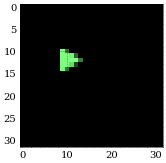

:- not object(o1,green,triangle,dark,small). :- not object(o2,black,bg, bg, bg). :- not object(o3,black,bg, bg, bg). :- not object(o4,black,bg, bg, bg). 
The model says:
there is a bg bg black bg in the image.
there is a bg bg black bg in the image.
there is a bg bg black bg in the image.
there is a small dark brown circle in the image.

with probabilities:
   red,    blue,  green, gray,  brown,magenta,cyan, yellow, black, circle, triangle, square, bg
s0 [0.017, 0.005, 0.160, 0.021, 0.058, 0.003, 0.002, 0.117, 0.617] [0.178, 0.200, 0.130, 0.492]
s1 [0.005, 0.002, 0.017, 0.011, 0.016, 0.001, 0.001, 0.008, 0.940] [0.013, 0.028, 0.007, 0.952]
s2 [0.005, 0.002, 0.018, 0.011, 0.017, 0.001, 0.001, 0.008, 0.937] [0.013, 0.026, 0.007, 0.955]
s3 [0.159, 0.015, 0.202, 0.114, 0.248, 0.018, 0.022, 0.210, 0.013] [0.342, 0.311, 0.331, 0.016]
   bright, dark,  bg,     small, big,   bg
s0 [0.215, 0.169, 0.616] [0.316, 0.233, 0.451]
s1 [0.010, 0.006, 0.984] [0.071, 0.010, 0.919]
s2 [0.011, 0.006, 0.983

In [7]:
idx = int(np.random.rand()* len(dataList))

#forward the image through the pretrained slot masks to get a feeling how the attention binary maps look like
with torch.no_grad():
    recon_combined, recons, masks, slots  = slot_net_obj_discovery(dataList[idx]['im'])

masks = masks.squeeze() 


img = np.einsum("abc->bca",dataList[idx]['im'].cpu().numpy().squeeze())
recon_img = np.einsum("abc->bca", recon_combined.numpy().squeeze())


plt.imshow((img+1)/2)

plt.show()

print(obsList[idx])


#get the predictions of what is in the image
inference, out = SLASHPobj.infer_batch(slot_net=slot_net, data_batch= dataList[idx])

print("The model says:")
interpret_inference(inference)


print("\nwith probabilities:")

print("   red,    blue,  green, gray,  brown,magenta,cyan, yellow, black, circle, triangle, square, bg")

for slot in inference.keys():
    
    color = ("["+', '.join(['%.3f']*9)+"]") % tuple(inference[slot]['color'].cpu().numpy()[0])
    shape = ("["+', '.join(['%.3f']*4)+"]") % tuple(inference[slot]['shape'].cpu().numpy()[0])
    print(slot,color,shape)
    
print("   bright, dark,  bg,     small, big,   bg")

for slot in inference.keys():
    shade = ("["+', '.join(['%.3f']*3)+"]") % tuple(inference[slot]['shade'].cpu().numpy()[0])
    size = ("["+', '.join(['%.3f']*3)+"]") % tuple(inference[slot]['size'].cpu().numpy()[0])
    print(slot,shade,size)
    
 
print("\n Our GT is:\n",obsList[idx])



In [8]:
dataListArray = np.array(dataList)
inference, _ = SLASHPobj.infer_batch(slot_net=slot_net, data_batch= dataListArray[:])


target = np.array(objList)

#compute the average precision, tp, fp, tn for color+shape, color, shape
pred = utils.inference_map_to_array(inference).cpu().numpy()



print(pred.shape,target.shape)

ap, true_positives, false_positives, true_negatives, correctly_classified = utils.average_precision(pred, target,-1, "SHAPEWORLD4")
print("avg precision ",ap, "tp", true_positives, "fp", false_positives, "tn", true_negatives, "correctly classified",correctly_classified)


#color
pred_c = utils.inference_map_to_array(inference, only_color=True).cpu().numpy()
ap_c, true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c  = utils.average_precision(pred, target,-1, "SHAPEWORLD4", only_color = True)
print("avg precision color",ap_c, "tp", true_positives_c, "fp", false_positives_c, "tn", true_negatives_c, "correctly classified",correctly_classified_c)

#shape              
pred_s = utils.inference_map_to_array(inference, only_shape=True).cpu().numpy()
ap_s, true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s= utils.average_precision(pred_s, target,-1, "SHAPEWORLD4", only_shape = True)
print("avg precision shape",ap_s, "tp", true_positives_s, "fp", false_positives_s, "tn", true_negatives_s, "correctly classified",correctly_classified_s)

#shade              
pred_h = utils.inference_map_to_array(inference, only_shade=True).cpu().numpy()
ap_h, true_positives_h, false_positives_h, true_negatives_h, correctly_classified_h= utils.average_precision(pred_h, target,-1, "SHAPEWORLD4", only_shade = True)
print("avg precision shade",ap_h, "tp", true_positives_h, "fp", false_positives_h, "tn", true_negatives_h, "correctly classified",correctly_classified_h)

#shape              
pred_x = utils.inference_map_to_array(inference, only_size=True).cpu().numpy()
ap_x, true_positives_x, false_positives_x, true_negatives_x, correctly_classified_x= utils.average_precision(pred_x, target,-1, "SHAPEWORLD4", only_size = True)
print("avg precision size",ap_x, "tp", true_positives_x, "fp", false_positives_x, "tn", true_negatives_x, "correctly classified",correctly_classified_x)

(5000, 4, 20) (5000, 4, 20)


../utils.py:436: RuntimeWarning: invalid value encountered in true_divide
  precision_array = np.divide(accumulated_tp, (accumulated_fp + accumulated_tp))


avg precision  0.002525741130316783 tp 598.0 fp 12371.0 tn 7031.0 correctly classified 48
avg precision color 0.14625904026000125 tp 4800.0 fp 8182.0 tn 7018.0 correctly classified 464
avg precision shape 0.2562349754691269 tp 6393.0 fp 6604.0 tn 7003.0 correctly classified 683
avg precision shade 0.34529140865723384 tp 7094.0 fp 5888.0 tn 7018.0 correctly classified 1053
avg precision size 0.5414751780866967 tp 8899.0 fp 4082.0 tn 7019.0 correctly classified 1703


## Log Likelihoods
circle 0, triangle 1, square 2
red 0, blue 1, green 2
            

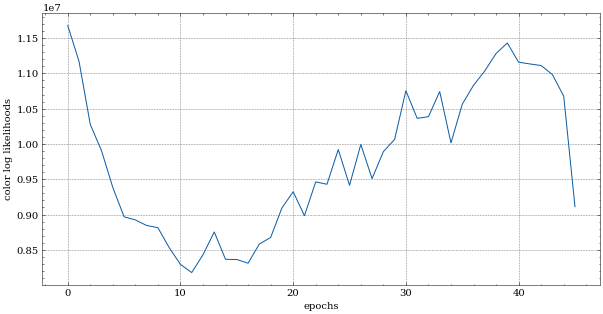

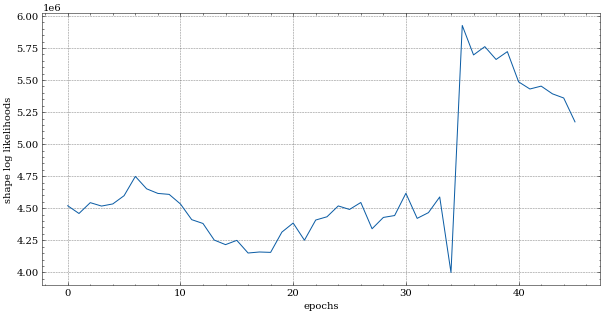

In [9]:
test_ll_list = models['test_ll_list']

temp= np.zeros((len(test_ll_list), 3))


for i, ll in enumerate(test_ll_list):
    temp[i,0] = ll[1]
    temp[i,1] = ll[0][0]
    temp[i,2] = ll[0][1]

x = temp.shape[0]
x= 250
sign = -1
if exp_dict['use_em']:
    sign = 1
    
fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,1], label="c")
plt.xlabel("epochs")
plt.ylabel("color log likelihoods")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,2])
plt.xlabel("epochs")
plt.ylabel("shape log likelihoods")
plt.show()

plt.show()



# Average Precision 

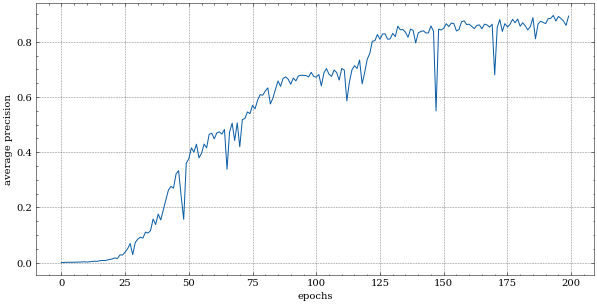

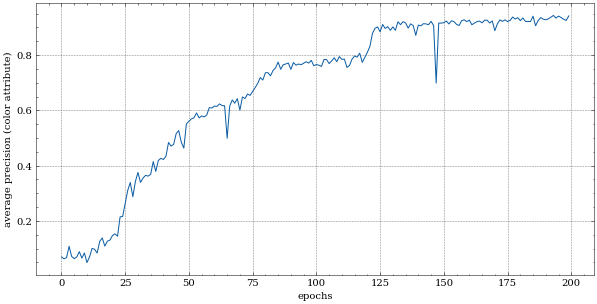

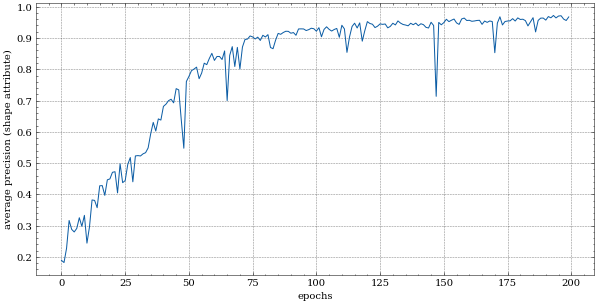

In [9]:
test_ap_list = models['test_ap_list_a']
test_ap_list = np.array(test_ap_list)

#"test_ap_list_a":test_ap_list_a,
#"test_ap_list_b":test_ap_list_b,
#"test_metric_list_a":test_metric_list_a,
#"test_metric_list_b":test_metric_list_b,


x= 200


fig = plt.figure(figsize=(10,5))    
plt.plot(test_ap_list[:x,3], test_ap_list[:x,0], label="c")
plt.xlabel("epochs")
plt.ylabel("average precision")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(test_ap_list[:x,3], test_ap_list[:x,1], label="c")
plt.xlabel("epochs")
plt.ylabel("average precision (color attribute)")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(test_ap_list[:x,3], test_ap_list[:x,2], label="c")
plt.xlabel("epochs")
plt.ylabel("average precision (shape attribute)")
plt.show()

plt.show()



### lr rates

/home/dochs/anaconda3/envs/env_dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


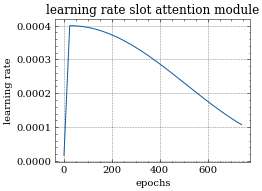

In [11]:
lr_list = np.array( models['lr_list'])
epochs = lr_list[:,1]
lr=np.stack(lr_list[:,0])

fig1, ax1 = plt.subplots()


#fig = plt.figure()  
ax1.set_title("learning rate slot attention module")
ax1.set_ylabel("learning rate")
ax1.set_xlabel("epochs")


ax1.plot(epochs, lr[:,1])

fig1.savefig('plots/learning_rate.svg', format="svg")
plt.show()


(743, 4)
argmax 679


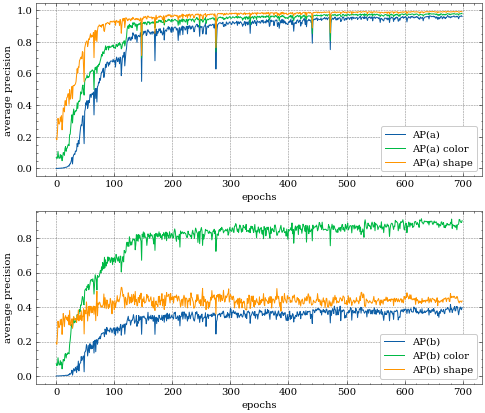

In [36]:
model_paths = ["most_prob_pd_endtoend", "most_prob_bt_endtoend", "most_prob_pd_pretrained" , "most_prob_bt_pretrained"]

#"test_ap_list_a":test_ap_list_a,
#"test_ap_list_b":test_ap_list_b,
#"test_metric_list_a":test_metric_list_a,
#"test_metric_list_b":test_metric_list_b,
test_ap_list_a = models['test_ap_list_a']
test_ap_list_b = models['test_ap_list_b']

test_ap_list_a = np.array(test_ap_list_a)
test_ap_list_b = np.array(test_ap_list_b)


x= 700


fig, ax = plt.subplots(2, figsize=(8,7))


ax[0].set_xlabel("epochs")
ax[0].set_ylabel("average precision")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("average precision")

#ap, ap_c, ap_s, ap_h, ap_x, e

print(test_ap_list_a.shape)

ax[0].plot(test_ap_list_a[:x,3], test_ap_list_a[:x,0], label="AP(a)")
ax[0].plot(test_ap_list_a[:x,3], test_ap_list_a[:x,1], label="AP(a) color")
ax[0].plot(test_ap_list_a[:x,3], test_ap_list_a[:x,2], label="AP(a) shape")


ax[1].plot(test_ap_list_b[:x,3], test_ap_list_b[:x,0], label="AP(b)")
ax[1].plot(test_ap_list_b[:x,3], test_ap_list_b[:x,1], label="AP(b) color")
ax[1].plot(test_ap_list_b[:x,3], test_ap_list_b[:x,2], label="AP(b) shape")
#ax.plot(test_ap_list_b[:x,2], test_ap_list_b[:x,1], label="AP test")



print("argmax",np.argmax(test_ap_list_b[:x,0]))

ax[0].legend(loc='lower right')#, bbox_to_anchor=(0.5, 0.13, 0.4, 0.3))

ax[1].legend(loc='lower right')#, bbox_to_anchor=(0.5, 0.13, 0.4, 0.2))

fig.savefig('plots/ap_cogent.svg', format="svg")

plt.show()

# true positives

[ 6212.  6338.  7450.  1211. 11340.  1210.  7450.  3881.  7090.  5460.
  7450.  1306.]


NameError: name 'max_value' is not defined

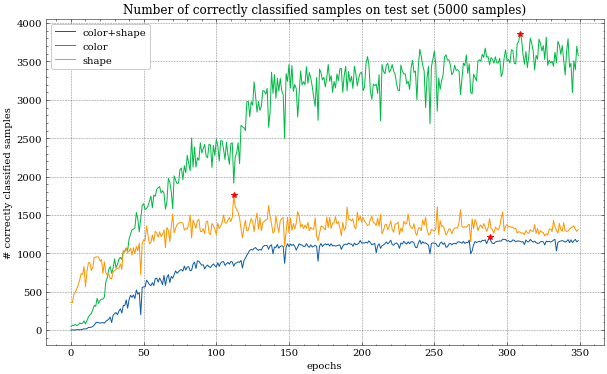

In [44]:
"""
test_metric_list.append([true_positives, false_positives, true_negatives,correctly_classified,
                         true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c,
                         true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s])
                         
test_metric_list_b.append([true_positives, false_positives, true_negatives, correctly_classified,
                                 true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c,
                                 true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s])

                    "test_metric_list_a":test_metric_list_a,
                    "test_metric_list_b":test_metric_list_b,
"""



test_metric_list = np.array(models['test_metric_list_b'])

correctly_classified =  test_metric_list[:350,3]
correctly_classified_color =  test_metric_list[:350,7]
correctly_classified_shape =  test_metric_list[:350,11]


print(test_metric_list[679])




fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title("Number of correctly classified samples on test set (5000 samples)")
ax1.set_ylabel("# correctly classified samples")
ax1.set_xlabel("epochs")

ax1.plot(correctly_classified, label="color+shape")
ax1.plot(np.argmax(correctly_classified), np.max(correctly_classified), 'r*')

ax1.plot(correctly_classified_color, label="color")
ax1.plot(np.argmax(correctly_classified_color), np.max(correctly_classified_color), 'r*')

ax1.plot(correctly_classified_shape, label="shape")
ax1.plot(np.argmax(correctly_classified_shape), np.max(correctly_classified_shape), 'r*')


ax1.legend()


fig1.savefig('plots/correctly_classified.svg', format="svg")


print(max_value, max_index)
plt.plot()

true_positives, false_positives, true_negatives, correctly_classified,
                                 true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c,
                                 true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s])

    [ 6212.  6338.  7450.  1211. 
    11340.  1210.  7450.  3881.
    7090.  5460. 7450.  1306.]
    
Iteration 679 -> highest AP for condition B
number of objects in test set: 12492
number of backgrounds in test set: 7508
5000 img * 4 slots = 12492 + 7508 = 20.000

      | true positives | false positives | true negatives | correctly classified(5000 images)
all   | 6212           | 6338            | 7450           | 1211
color | 11340          | 1210            | 7450           | 3881
shape | 7090           | 5460            | 7450           | 1306
